# Home assigment 3

Please give your name below:

In [ ]:
name='Alexander Hedene'

## Exercise 3

A hypothetical dictatorship is desperately trying to build a nuclear weapon. Several years ago they have managed to acquire the design of a graphite moderated, CO2 cooled, natural uranium fuelled reactor. Your country's intelligence agency asked you to estimate the amount of plutonium the reactor produced in the previous years. You will need to make a pincell model of the reactor, and perform a depletion calculation.

The following information is available to you:

The fuel pin is made of UAl (density is 18.167 g/cm3) with the following atomic percentage:
- U235  0.00707444999
- U238  0.98792555
- Al27  0.005  

The cladding is made of a mixture of Magnesium and Aluminium (density is 1.738 g/cm3), with the following weight fractions:
- Mg 0.99
- Al27 0.01
(Note that you can add Mg as an element, and you can set weight fractions instead of atomic with `add_element('Mg',0.99,percent_type='wo')`) 

The fuel is cooled with CO2, however you know that due to its low density you can neglect it for now.

The moderator is made of graphite (density is 1.7 g/cm3). For this you can `add_nuclide('C0',1)` and set the thermal scattering laws with `add_s_alpha_beta('c_Graphite')`.

The geometry is the following:
- fuel outer radius is 1.45 cm
- clad outer radius is 1.5 cm (there is no gap between the clad and the fuel)
- the coolant channel outer radius is 3.25 cm
- outside the coolant we have the graphite moderator
- the pitch of the pincell is 20.0 cm.

The active core height is 52 cm, and there are 8120 such pincells in the reactor. (This information you do not need for the openMC input, however it is necessary later to calculate the amount of fuel.)

You know from your intel, that the reactor was running for 1785 continous days (which you can simulate with eight 223.125 days long steps) with a power density of 0.336 W/gHM. 

1. Create the openMC model for the pincell (you do not need to include any tallies)
2. Perform a depletion calculation
3. Look at the change of the k-eigenvalue over time, just because you are a curious reactor physicist
4. Estimate the total mass of Pu-239 at the end of the 1785 days operation (in kg)
5. Calculate the Plutonium-vector (the weight% of Pu-238, Pu-239, Pu-240, Pu-241, Pu-242 in the total amount of plutonium), to see whether the material would qualify as weapon grade or reactor grade plutonium (for this read up on weapon and reactor grade plutonium!).

(Note, in case you have difficulties with running the problem -which might happen with the virtual machine and limited computational resources-, then you can find the output files in the '/results' folder. Nevertheless, you still need to implement the geometry, run a simple k-eigenvalue calculation and create a plot of the geometry to show that your implementation is working. But then you can use the available output for processing).

In [4]:
!pip install periodictable
import openmc
import math
import os
import numpy as np
import matplotlib.pyplot as plt
import periodictable
import re 


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [5]:


def pincell():
    uo2 = openmc.Material(1,"uo2")
    uo2.id = 1
    # Adding nuclides to uo2
    uo2.add_nuclide('U235', 0.00707444999)
    uo2.add_nuclide('U238', 0.98792555)
    uo2.add_nuclide('Al27', 0.005)
    uo2.set_density('g/cm3', 18.167)
    uo2.depletable = True
    fuel_vol = np.pi * 1.45**2  # cm2
    uo2.volume = fuel_vol

    #cladding
    MgAl = openmc.Material(name='Mg-Al clad')
    MgAl.set_density('g/cm3', 1.738)
    MgAl.add_element('Mg',0.99,percent_type='wo')
    MgAl.add_element('Al',0.01,percent_type='wo')

    #moderator
    graphite = openmc.Material(name="graphite")
    graphite.add_nuclide('C0',1)
    graphite.set_density('g/cm3', 1.7)
    graphite.add_s_alpha_beta('c_Graphite')

    

    
    mats = openmc.Materials([uo2, MgAl, graphite])


    fuel_or = openmc.ZCylinder(r=1.45) #fuel cylinder with outer radius
    clad_or = openmc.ZCylinder(r=1.5) #clad outer cylinder with outer radius
    coolant_or = openmc.ZCylinder(r=3.25) #coolant outer cylinder with outer radius

    fuel_region = -fuel_or                #inside the fuel cylinder
    clad_region = +fuel_or & -clad_or     #outside of clad inner cylinder and inside of clad outer cylinder
    coolant_region =  +clad_or & -coolant_or   # Cooler region
    
    fuel = openmc.Cell(1, name='fuel')
    fuel.fill = uo2
    fuel.region = fuel_region

    clad = openmc.Cell(2, name='clad')
    clad.fill = MgAl
    clad.region = clad_region
    
    coolant = openmc.Cell(3, name='vacuum region (coolant)')
    coolant.region = coolant_region 
    # Since this is empty i did not add any material


    pitch = 20.0
    #we define the x and y planes with boundary condition
    left = openmc.XPlane(x0=-pitch/2, boundary_type='reflective')
    right = openmc.XPlane(x0=pitch/2, boundary_type='reflective')
    bottom = openmc.YPlane(y0=-pitch/2, boundary_type='reflective')
    top = openmc.YPlane(y0=pitch/2, boundary_type='reflective')

    #outside of left and inside of right, outside of bottom, and inside of top and outside of clad outer cylinder
    graphite_region = +left & -right & +bottom & -top & +coolant_or

    moderator = openmc.Cell(4,name='moderator')
    moderator.fill = graphite
    moderator.region = graphite_region

    root = openmc.Universe(cells=(fuel, clad, coolant, moderator))

    geom = openmc.Geometry()
    geom.root_universe = root

    point = openmc.stats.Point((0, 0, 0))
    src = openmc.Source(space=point)

    # Watch out for these settings. I wanted good results so i ran with heavy settings whichs was time consuming.
    settings = openmc.Settings()
    settings.source = src
    settings.batches = 120
    settings.inactive = 20
    settings.particles = 20000
    settings.output = {'tallies': False}

    model = openmc.model.Model(geom, mats, settings)
    return model

In [6]:
import openmc.deplete
import os
model = pincell()
model.export_to_xml()
operator = openmc.deplete.CoupledOperator(model, '/root/chain_casl_pwr.xml')

powdens = 0.336 #W/gHM; this power density corresponds to 10MWd/kgHM burnup over one year


days = np.ones(8)*223.125 # days

integrator = openmc.deplete.PredictorIntegrator(operator, timesteps=days,
                                                power_density=powdens, timestep_units='d')
integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading Mo95 from /root/endfb-vii.1-hdf5/neutron/Mo95.h5
 Reading Mo96 from /root/endfb-vii.1-hdf5/neutron/Mo96.h5
 Reading Mo97 from /root/endfb-vii.1-hdf5/neutron/Mo97.h5
 Reading Mo98 from /root/endfb-vii.1-hdf5/neutron/Mo98.h5
 Reading Mo99 from /root/endfb-vii.1-hdf5/neutron/Mo99.h5
 Reading Mo100 from /root/endfb-vii.1-hdf5/neutron/Mo100.h5
 Reading Tc99 from /root/endfb-vii.1-hdf5/neutron/Tc99.h5


 Reading Ru100 from /root/endfb-vii.1-hdf5/neutron/Ru100.h5
 Reading Ru101 from /root/endfb-vii.1-hdf5/neutron/Ru101.h5
 Reading Ru102 from /root/endfb-vii.1-hdf5/neutron/Ru102.h5
 Reading Ru103 from /root/endfb-vii.1-hdf5/neutron/Ru103.h5
 Reading Ru104 from /root/endfb-vii.1-hdf5/neutron/Ru104.h5
 Reading Ru105 from /root/endfb-vii.1-hdf5/neutron/Ru105.h5
 Reading Ru106 from /root/endfb-vii.1-hdf5/neutron/Ru106.h5
 Reading Rh103 from /root/endfb-vii.1-hdf5/neutron/Rh103.h5
 Reading Rh105 from /root/endfb-vii.1-hdf5/neutron/Rh105.h5
 Reading Pd104 from /root/endfb-vii.1-hdf5/neutron/Pd104.h5
 Reading Pd105 from /root/endfb-vii.1-hdf5/neutron/Pd105.h5
 Reading Pd106 from /root/endfb-vii.1-hdf5/neutron/Pd106.h5
 Reading Pd107 from /root/endfb-vii.1-hdf5/neutron/Pd107.h5
 Reading Pd108 from /root/endfb-vii.1-hdf5/neutron/Pd108.h5
 Reading Ag107 from /root/endfb-vii.1-hdf5/neutron/Ag107.h5
 Reading Ag109 from /root/endfb-vii.1-hdf5/neutron/Ag109.h5
 Reading Ag110_m1 from /root/endfb-vii.1

 Reading Xe132 from /root/endfb-vii.1-hdf5/neutron/Xe132.h5
 Reading Xe133 from /root/endfb-vii.1-hdf5/neutron/Xe133.h5
 Reading Xe134 from /root/endfb-vii.1-hdf5/neutron/Xe134.h5
 Reading Xe135 from /root/endfb-vii.1-hdf5/neutron/Xe135.h5
 Reading Xe136 from /root/endfb-vii.1-hdf5/neutron/Xe136.h5
 Reading Cs133 from /root/endfb-vii.1-hdf5/neutron/Cs133.h5


          2500K


 Reading Cs134 from /root/endfb-vii.1-hdf5/neutron/Cs134.h5
 Reading Cs135 from /root/endfb-vii.1-hdf5/neutron/Cs135.h5
 Reading Cs136 from /root/endfb-vii.1-hdf5/neutron/Cs136.h5
 Reading Cs137 from /root/endfb-vii.1-hdf5/neutron/Cs137.h5
 Reading Ba134 from /root/endfb-vii.1-hdf5/neutron/Ba134.h5
 Reading Ba137 from /root/endfb-vii.1-hdf5/neutron/Ba137.h5


          1200K
          2500K


 Reading Ba140 from /root/endfb-vii.1-hdf5/neutron/Ba140.h5
 Reading La139 from /root/endfb-vii.1-hdf5/neutron/La139.h5
 Reading La140 from /root/endfb-vii.1-hdf5/neutron/La140.h5
 Reading Ce140 from /root/endfb-vii.1-hdf5/neutron/Ce140.h5
 Reading Ce141 from /root/endfb-vii.1-hdf5/neutron/Ce141.h5
 Reading Ce142 from /root/endfb-vii.1-hdf5/neutron/Ce142.h5
 Reading Ce143 from /root/endfb-vii.1-hdf5/neutron/Ce143.h5
 Reading Ce144 from /root/endfb-vii.1-hdf5/neutron/Ce144.h5
 Reading Pr141 from /root/endfb-vii.1-hdf5/neutron/Pr141.h5
 Reading Pr142 from /root/endfb-vii.1-hdf5/neutron/Pr142.h5
 Reading Pr143 from /root/endfb-vii.1-hdf5/neutron/Pr143.h5
 Reading Nd142 from /root/endfb-vii.1-hdf5/neutron/Nd142.h5
 Reading Nd143 from /root/endfb-vii.1-hdf5/neutron/Nd143.h5
 Reading Nd144 from /root/endfb-vii.1-hdf5/neutron/Nd144.h5
 Reading Nd145 from /root/endfb-vii.1-hdf5/neutron/Nd145.h5
 Reading Nd146 from /root/endfb-vii.1-hdf5/neutron/Nd146.h5
 Reading Nd147 from /root/endfb-vii.1-hd

          1200K
          2500K


 Reading Eu157 from /root/endfb-vii.1-hdf5/neutron/Eu157.h5
 Reading Gd152 from /root/endfb-vii.1-hdf5/neutron/Gd152.h5
 Reading Gd154 from /root/endfb-vii.1-hdf5/neutron/Gd154.h5
 Reading Gd155 from /root/endfb-vii.1-hdf5/neutron/Gd155.h5
 Reading Gd156 from /root/endfb-vii.1-hdf5/neutron/Gd156.h5
 Reading Gd157 from /root/endfb-vii.1-hdf5/neutron/Gd157.h5
 Reading Gd158 from /root/endfb-vii.1-hdf5/neutron/Gd158.h5
 Reading Gd160 from /root/endfb-vii.1-hdf5/neutron/Gd160.h5
 Reading Tb159 from /root/endfb-vii.1-hdf5/neutron/Tb159.h5
 Reading Tb160 from /root/endfb-vii.1-hdf5/neutron/Tb160.h5
 Reading Dy160 from /root/endfb-vii.1-hdf5/neutron/Dy160.h5
 Reading Dy161 from /root/endfb-vii.1-hdf5/neutron/Dy161.h5
 Reading Dy162 from /root/endfb-vii.1-hdf5/neutron/Dy162.h5
 Reading Dy163 from /root/endfb-vii.1-hdf5/neutron/Dy163.h5
 Reading Dy164 from /root/endfb-vii.1-hdf5/neutron/Dy164.h5
 Reading Ho165 from /root/endfb-vii.1-hdf5/neutron/Ho165.h5
 Reading Er162 from /root/endfb-vii.1-hd

/usr/local/lib/python3.9/dist-packages/openmc/deplete/results.py:90: FutureWarning: The ResultsList.from_hdf5(...) method is no longer necessary and will be removed in a future version of OpenMC. Use Results(...) instead.
  warn(


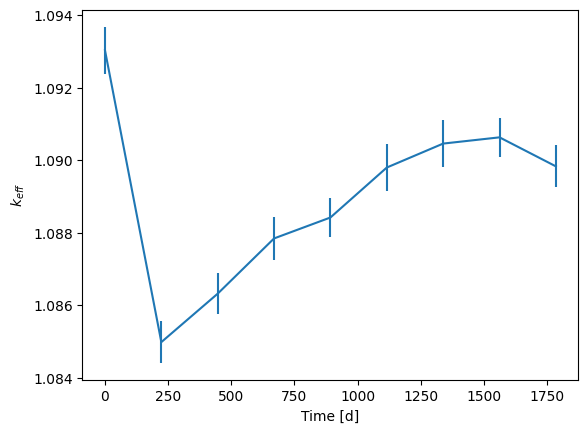

In [7]:
results = openmc.deplete.Results.from_hdf5("./depletion_results.h5")
time, k = results.get_keff() # Get results
time /= (24 * 60 * 60)  # convert back to days from seconds


plt.errorbar(time, k[:, 0], yerr=k[:, 1])
plt.xlabel('Time [d]')
plt.ylabel('$k_{eff}$')
plt.show()

In [8]:


# This was probably over-complicating it a lot, but I had to finsih this after i begun...
def get_mass_from_atom_dens(isotopes):
    """
    Calculate the total mass of specified isotopes in the reactor.
    
    Parameters
    ----------
    isotopes : list of str
        List of isotopes as strings, e.g., ['Pu239', 'Pu240']
    
    Returns
    -------
    np.array
        Mass of each isotope in kg
    """
    
    mass_list = []  # To store mass of each isotope
    Na = 6.02214076e+23  # Avogadro's number [atoms/mol]
    vol = np.pi * 1.45**2 * 50  # Volume of a single pin [cm^3]; pi*r^2*h
    
    # Loop over each isotope
    for atom in isotopes:
        # Split the string into element symbol and mass number using regex
        symbol, mass_number = re.match(r"([a-zA-Z]+)(\d+)", atom).groups()
        mass_number = int(mass_number)  # Convert mass number to integer

        # Get isotope mass in grams per mole using periodictable library
        M = getattr(periodictable, symbol.capitalize())[mass_number].mass

        # Get the atom concentration from OpenMC depletion results
        # _time is ignored; u5 is the array of number densities over time in atom/b-cm
        _time, u5 = results.get_atoms("1", atom, nuc_units='atom/b-cm')

        # Take the final concentration (last timestep) and convert to atom/cm^3
        final_conc_cm3 = 1e+24 * u5[-1]  # convert from atom/b-cm to atom/cm^3

        # Compute mass of isotope in a single pin
        mass_single_pin = (final_conc_cm3 * vol) / Na * M  # [g]

        # Compute total mass in the reactor (8120 pins) and convert to kg
        mass_tot = mass_single_pin * 8120 / 1e+3  # [kg]

        # Append the result to the mass list
        mass_list.append(mass_tot)

    # Return masses as a numpy array
    return np.array(mass_list)

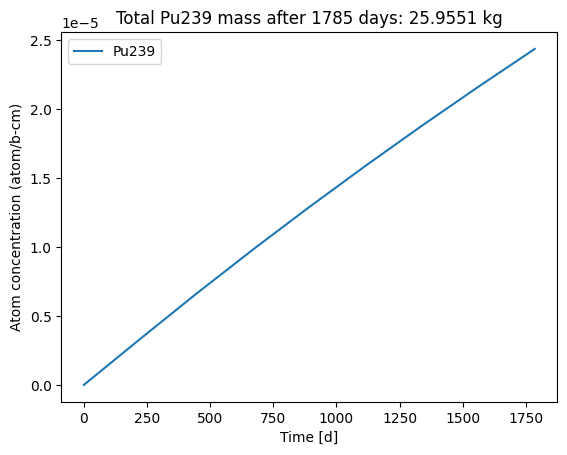

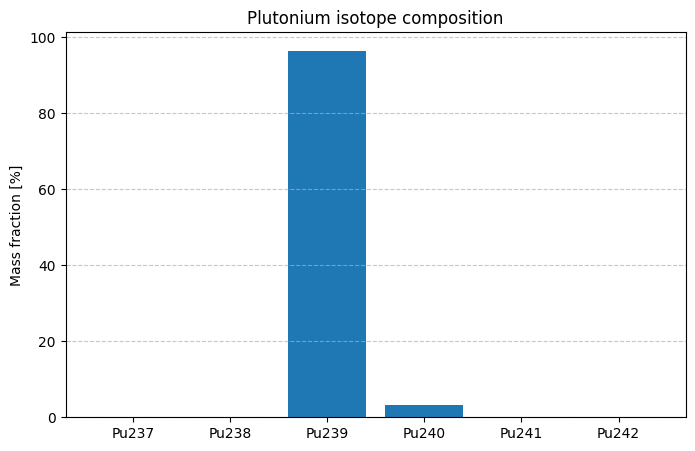

In [10]:
_time, u5 = results.get_atoms("1", 'Pu239',nuc_units='atom/b-cm') #we call it _time, because we already have a time variable in the correct day units which we intend to use      

# Define the plutonium isotopes of interest
pu_isotopes = ['Pu237', 'Pu238', 'Pu239', 'Pu240', 'Pu241', 'Pu242']

# Custom function that returns the mass of each isotope (in kg) for the entire reactor
pu_mass_array = get_mass_from_atom_dens(pu_isotopes)

# Plot Pu239 atom concentration over irradiation time
plt.plot(time, u5, label='Pu239')
plt.xlabel("Time [d]")  # time in days
plt.ylabel("Atom concentration (atom/b-cm)")  # number density
plt.title(f'Total Pu239 mass after 1785 days: {pu_mass_array[2]:.4f} kg')  # title includes final Pu239 mass
plt.legend()
plt.show()

# Calculate total plutonium mass and normalize to get isotopic fractions
pu_tot_mass = np.sum(pu_mass_array)
Plutonium_vector = pu_mass_array / pu_tot_mass  # fractional mass of each isotope, i.e. plutonium vector.

# Plot  plutonium vector as a bar chart
plt.figure(figsize=(8, 5))
plt.bar(pu_isotopes, Plutonium_vector*100)
plt.ylabel('Mass fraction [%]')  # fraction of total Pu mass (0–1 scale)
plt.title('Plutonium isotope composition')
plt.grid(axis='y', linestyle='--', alpha=0.7)



# Conclusion
The final plutionum vector was:
Pu237 = 2.06271118e-09 %
Pu238 = 6.42970895e-03 %
Pu239 = 96.4531634 %
Pu240 = 3.35698885 %
Pu241 = 0.180369269 %
Pu242 = 3.04881181e-03 %


Since the plotunium has a higher Pu239 concentration than 93% (96.4531634) and a low Pu240 concentration this would qualify as weapon grade plotunium.